In [1]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [2]:
from transformers import ViTFeatureExtractor

model_ckpt = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_ckpt)

/home/rkn/.local/share/virtualenvs/lab-work-gFKfzxI5/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/rkn/.local/share/virtualenvs/lab-work-gFKfzxI5/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [3]:
images_root = '../Affectnet/Manually_Annotated/Manually_Annotated_Images'

In [4]:
import pandas as pd
from torch.utils.data import Dataset
from PIL import Image
import os

def pil_loader(path):
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')


class AffectNetDataset(Dataset):
    def __init__(self,
                 csvfile,
                 root,
                 mode='classification',
                 crop=False,
                 transform=None,
                 invalid_files=None):
        assert mode in ('valence', 'arousal', 'valence-arousal', 'classification')
        self.df = pd.read_csv(csvfile)
        self.root = root
        self.mode = mode
        self.crop = crop
        self.transform = transform
        self.invalid_files = invalid_files
        
        if self.invalid_files:
            self.df = self.df[~self.df['subDirectory_filePath'].isin(invalid_files)]
            self.df = self.df
        
        self.df = self.df[~((self.df['expression'] == 9) | (self.df['expression'] == 10))].reset_index(drop=True)
    
    def __getitem__(self, idx):
        try:
            img = pil_loader(os.path.join(self.root, self.df['subDirectory_filePath'][idx]))
        except KeyError:
            raise IndexError
        if self.crop:
            img = img.crop((self.df['face_x'][idx],
                            self.df['face_y'][idx],
                            self.df['face_x'][idx]+self.df['face_width'][idx],
                            self.df['face_y'][idx]+self.df['face_height'][idx],))
        if self.transform:
            img = self.transform(img)
        if self.mode == 'classification':
            target = torch.tensor(self.df['expression'][idx])
        elif self.mode == 'valence':
            target = torch.tensor([self.df['valence'][idx]])
        elif self.mode == 'arousal':
            target = torch.tensor([self.df['arousal'][idx]])
        else:
            target = torch.tensor([self.df['valence'][idx],
                                   self.df['arousal'][idx]])
        return img.float(), target.float()
    
    def __len__(self):
        return len(self.df)


class AffectNetDatasetForSupCon(Dataset):
    def __init__(self,
                 csvfile,
                 root,
                 transform,
                 return_labels=True,
                 crop=False,
                 invalid_files=None):
        self.df = pd.read_csv(csvfile)
        self.root = root
        self.crop = crop
        self.transform = transform
        self.return_labels = return_labels
        self.invalid_files = invalid_files
        
        if self.invalid_files:
            self.df = self.df[~self.df['subDirectory_filePath'].isin(invalid_files)]
            self.df = self.df
        
        self.df = self.df[~((self.df['expression'] == 9) | (self.df['expression'] == 10))].reset_index(drop=True)
    
    def __getitem__(self, idx):
        try:
            img = pil_loader(os.path.join(self.root, self.df['subDirectory_filePath'][idx]))
        except KeyError:
            raise IndexError
        if self.crop:
            img = img.crop((self.df['face_x'][idx],
                            self.df['face_y'][idx],
                            self.df['face_x'][idx]+self.df['face_width'][idx],
                            self.df['face_y'][idx]+self.df['face_height'][idx],))
        img1 = self.transform(img)
        img2 = self.transform(img)
        if self.return_labels:
            target = torch.tensor(self.df['valence'][idx])
            if target < -0.5:
                target = torch.tensor(0)
            elif target > 0.5:
                target = torch.tensor(2)
            else:
                target = torch.tensor(1)
            return (img1.float(), img2.float()), target
        else:
            return img1.float(), img2.float()
    
    def __len__(self):
        return len(self.df)

In [5]:
def contrastive_collate_fn(examples):
    imgs, targets = zip(*examples)
    imgs1, imgs2 = zip(*imgs)
    imgs1 = torch.stack(imgs1)
    imgs2 = torch.stack(imgs2)
    pixel_values = torch.cat([imgs1, imgs2])
    targets = torch.stack(targets)
    return {'pixel_values': pixel_values, 'labels': targets}

In [6]:
train_invalid_files = ['103/29a31ebf1567693f4644c8ba3476ca9a72ee07fe67a5860d98707a0a.jpg']
val_invalid_files = []

In [7]:
from torchvision.transforms import (Compose,
                                    Normalize,
                                    Resize,
                                    RandomResizedCrop,
                                    RandomHorizontalFlip,
                                    RandomApply,
                                    ColorJitter,
                                    RandomGrayscale,
                                    ToTensor)

normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)

supcon_transform = Compose([
    RandomResizedCrop(size=tuple(feature_extractor.size.values()), scale=(0.2, 1.)),
    RandomHorizontalFlip(),
    RandomApply([
        ColorJitter(0.4, 0.4, 0.4, 0.1)
    ], p=0.8),
    RandomGrayscale(p=0.2),
    ToTensor(),
    normalize
])

contrastive_dataset = AffectNetDatasetForSupCon('../Affectnet/training.csv',
                                                images_root,
                                                crop=False,
                                                transform=supcon_transform,
                                                invalid_files=train_invalid_files)

print('contrastive:', len(contrastive_dataset))

contrastive: 320739


In [8]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(contrastive_dataset, collate_fn=contrastive_collate_fn, batch_size=4)

batch = next(iter(train_dataloader))
for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k, v.shape)

pixel_values torch.Size([8, 3, 224, 224])
labels torch.Size([4])


In [9]:
from transformers import Trainer

from SupContrast.losses import SupConLoss

class SupConTrainer(Trainer):
    def __init__(self,
                 model = None,
                 args = None,
                 data_collator = None,
                 train_dataset = None,
                 eval_dataset = None,
                 tokenizer = None,
                 model_init = None,
                 compute_metrics = None,
                 callbacks = None,
                 optimizers = (None, None),
                 preprocess_logits_for_metrics = None):
        super().__init__(model, args, data_collator, train_dataset, eval_dataset, tokenizer, model_init, compute_metrics, callbacks, optimizers, preprocess_logits_for_metrics)
        self.loss_fct = SupConLoss()
    
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get('labels')
        bsz = labels.shape[0]
        outputs = model(pixel_values=inputs.get('pixel_values'), output_hidden_states=True)
        features = outputs.get('logits')
        f1, f2 = torch.split(features, [bsz, bsz])
        features = torch.cat([f1.unsqueeze(1), f2.unsqueeze(1)], dim=1)
        loss = self.loss_fct(features, labels)
        return (loss, features) if return_outputs else loss

In [10]:
from transformers import ViTForImageClassification

model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k',
                                                  num_labels=128,
                                                  problem_type='regression')


Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
from transformers import TrainingArguments
import wandb

wandb.init(project='AffectNet-vit', group='affectnet-contrastive', name='valencelabel-SupCon-pretrain_test')

contrastive_args = TrainingArguments(
    f"affectnet-valence-supcon__",
    save_strategy='epoch',
    learning_rate=1e-6,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=1e-3,
    logging_dir='contrastive-logs',
    logging_strategy='steps',
    logging_steps=1000,
    remove_unused_columns=False,
    report_to='wandb'
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: rkn. Use `wandb login --relogin` to force relogin


In [12]:
trainer = SupConTrainer(
    model,
    contrastive_args,
    train_dataset=contrastive_dataset,
    data_collator=contrastive_collate_fn,
    tokenizer=feature_extractor,
)

In [13]:
trainer.train()

/home/rkn/.local/share/virtualenvs/lab-work-gFKfzxI5/lib/python3.10/site-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
  0%|          | 0/60141 [00:00<?, ?it/s]

In [ ]:
trainer.save_state()
trainer.save_model()

In [ ]:
from tqdm import tqdm

def CLS_tokens(model, tokenizer, dataset, device):
    tokens = []
    labels = []
    for img, label in tqdm(dataset):
        # feature = tokenizer(img, return_tensors='pt').pixel_values.to(device)
        if isinstance(img, tuple):
            img = img[0]
        with torch.no_grad():
            token = model(img.unsqueeze(0).to(device), output_hidden_states=True).hidden_states[-1][0,0,:]
        tokens.append(token.cpu())
        labels.append(label)
    return torch.stack(tokens).squeeze(), torch.tensor(labels)

In [ ]:
id2label = {0: 'Neutral',
            1: 'Happy',
            2: 'Sad',
            3: 'Surprise',
            4: 'Fear',
            5: 'Disgust',
            6: 'Anger',
            7: 'Contempt',
            8: 'None'}

labeled_valence = {
    0: 'valence < -0.5',
    1: '-0.5 <= valence <= 0.5',
    2: '0.5 < valence',
}

In [ ]:
from umap import UMAP

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import random

def plot_tokens(tokens, labels, n_neighbors, id2label):
    umap = UMAP(n_neighbors=n_neighbors)
    zs = umap.fit_transform(tokens.numpy())
    ys = labels.numpy()
    print(zs.shape)
    print(ys.shape)
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.set_xlabel('feature-1')
    ax.set_ylabel('feature-2')
    cmap = cm.get_cmap('gist_ncar')
    
    label2point = {}
    for x, y in zip(zs, ys):
        mp = ax.scatter(x[0], x[1],
                        alpha=1,
                        label=id2label[y],
                        # c=label2color[y],
                        c=y,
                        cmap=cmap,
                        vmin=0,
                        vmax=len(set(ys)),
                        s=3,)
        label2point[id2label[y]] = mp
    labels, handles = zip(*sorted(label2point.items()))
    fig.legend(handles, labels, loc='right')
    plt.show()


/home/rkn/.local/share/virtualenvs/lab-work-gFKfzxI5/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/rkn/.local/share/virtualenvs/lab-work-gFKfzxI5/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/rkn/.local/share/virtualenvs

In [ ]:
transform = Compose([Resize(tuple(feature_extractor.size.values())),
                     ToTensor(),
                     normalize])

val_label_dataset = AffectNetDataset('../Affectnet/validation.csv',
                                     images_root,
                                     transform=transform,
                                     invalid_files=val_invalid_files)

val_contrastive_dataset = AffectNetDatasetForSupCon('../Affectnet/validation.csv',
                                                    images_root,
                                                    crop=False,
                                                    transform=transform,
                                                    invalid_files=val_invalid_files)

100%|██████████| 4500/4500 [01:21<00:00, 55.42it/s]


(4500, 2)
(4500,)


/tmp/ipykernel_28906/3847203088.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('gist_ncar')


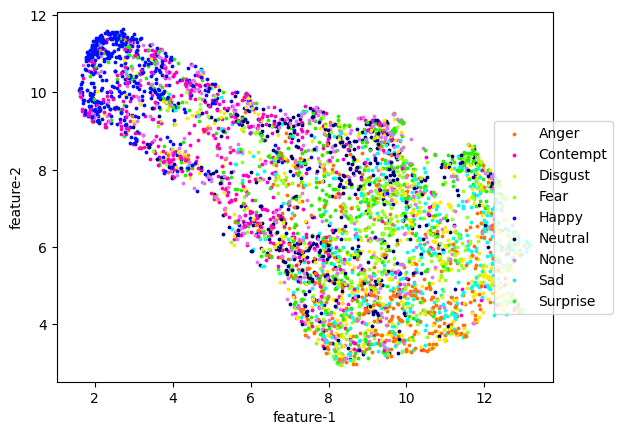

In [ ]:
tokens, labels = CLS_tokens(model,
                            feature_extractor,
                            val_label_dataset,
                            device)
plot_tokens(tokens, labels, 10, id2label)

100%|██████████| 4500/4500 [01:42<00:00, 43.97it/s]


(4500, 2)
(4500,)


/tmp/ipykernel_28906/3847203088.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('gist_ncar')


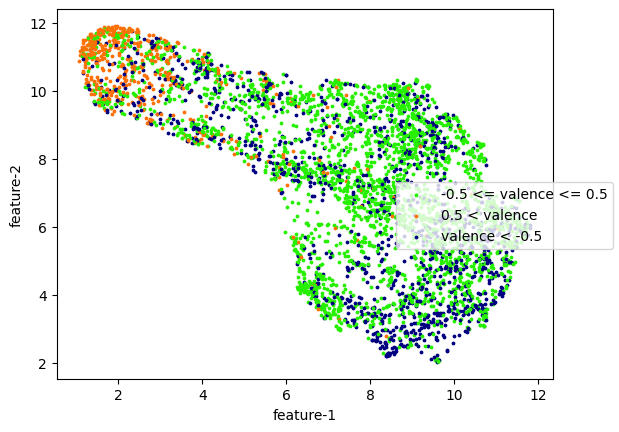

In [ ]:
tokens, labels = CLS_tokens(model,
                            feature_extractor,
                            # val_label_dataset,
                            val_contrastive_dataset,
                            device)
plot_tokens(tokens, labels, 10, labeled_valence)

In [ ]:
wandb.finish()

train/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
train/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
train/learning_rate,████▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
train/loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/total_flos,▁
train/train_loss,▁
train/train_runtime,▁
train/train_samples_per_second,▁
train/train_steps_per_second,▁
train/epoch,3.0
train/global_step,60141
